#  Applied computer vision: reading water consumption meters
## Computer vision project
### Faculty of Science of the University of Porto - Portugal.


## Example of images to be analyzed

In [1]:
# Load libraries needed for the project
import cv2
import numpy as np
import glob
import random
import pytesseract
from imutils import contours
from matplotlib import pyplot
from matplotlib import pyplot as plt
from keras.datasets import mnist
import matplotlib.pyplot as plt
import imutils
import pytesseract

Example of images to be analyzed

In [2]:
img1 = cv2.imread("Figures/id_26_value_252_131.jpg")
img2 = cv2.imread("Figures/id_29_value_127_491.jpg")
img3 = cv2.imread("Figures/id_35_value_469_334.jpg")

In [5]:
# Resize image
width = 320
height = 400
dim = (width, height)

img_redm1 = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)
img_redm2 = cv2.resize(img2, dim, interpolation = cv2.INTER_AREA)
img_redm3 = cv2.resize(img3, dim, interpolation = cv2.INTER_AREA)

In [29]:
# concatenate pictures
imgs_horizontal = np.concatenate((img_redm1, img_redm2, img_redm3), axis=1)

In [30]:
cv2.imshow("resized images", imgs_horizontal)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
# Save imagens
cv2.imwrite('exemplo.png', imgs_horizontal)

True

## Objective of the first part of the project: to locate the region of the digits

<img src="img_regiao_interesse.png">

 To locate the region of interest, containing the digits to be read, an artificial neural network "You only look once - yolo" was adopted. The network was trained with 500 images of water meters. 


### Note: The following codes were run on Google Colab

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
# Clone the Darknet
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# Compile Darknet using Nvidia GPU
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

In [ ]:
# Configure Darknet network for training YOLO V3
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg

In [ ]:
!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 4000/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=1@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=18@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=18@' cfg/yolov3_training.cfg

In [ ]:
# Create folder on google drive so that we can save there the weights
!mkdir "/mydrive/yolov3"

In [ ]:
!echo "meter" > data/obj.names
!echo -e 'classes= 1\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/yolov3' > data/obj.data
!mkdir data/obj

In [ ]:
# Download weights darknet model 53
!wget https://pjreddie.com/media/files/darknet53.conv.74

In [ ]:
# Extract Images
# The images need to be inside a zip archive called "images.zip" 
# and they need to be inside the folder "yolov3" on Google Drive
!unzip /mydrive/yolov3/images.zip -d data/obj

In [ ]:
# We're going to convert the class index on the .txt files. As we're working with 
# only one class, it's supposed to be class 0.
import glob
import os
import re

txt_file_paths = glob.glob(r"data/obj/*.txt")
for i, file_path in enumerate(txt_file_paths):
    # get image size
    with open(file_path, "r") as f_o:
        lines = f_o.readlines()

        text_converted = []
        for line in lines:
            print(line)
            numbers = re.findall("[0-9.]+", line)
            print(numbers)
            if numbers:

                # Define coordinates
                text = "{} {} {} {} {}".format(0, numbers[1], numbers[2], numbers[3], numbers[4])
                text_converted.append(text)
                print(i, file_path)
                print(text)
        # Write file
        with open(file_path, 'w') as fp:
            for item in text_converted:
                fp.writelines("%s\n" % item)

In [ ]:
import glob
images_list = glob.glob("data/obj/*.jpg")
print(images_list)

In [ ]:
#Create training.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

In [ ]:
# Start the training
!./darknet detector train data/obj.data cfg/yolov3_training.cfg darknet53.conv.74 -dont_show

End of code run on Google Colab. The trained model has been saved to the drive and will be used below

## Testing the trained model

In [3]:
# Load trained model
net = cv2.dnn.readNet("yolov3_training_last.weights", "yolov3_testing.cfg")

In [4]:
# Class name identified
classes = ["meter"]

In [5]:
# Load test image

#images_path = glob.glob(r"id_1008_value_95_912.jpg")
#images_path = glob.glob(r"id_1085_value_81_39.jpg")
#images_path = glob.glob(r"id_13_value_21_789.jpg")
images_path = glob.glob(r"id_1009_value_133_679.jpg")

In [6]:
# Resize images
width = 500
height = 650
dim = (width, height)

In [7]:
# Test 

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

random.shuffle(images_path)

for img_path in images_path:
    
    #Loading image
    img = cv2.imread(img_path)
    img = cv2.resize(img, dim)
    height, width, channels = img.shape

    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    # Showing informations on the screen
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.3:
                # Object detected
                print(class_id)
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    print(indexes)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            #cv2.putText(img, label, (x, y + 30), font, 3, color, 2)

    # cropping the image
    crop_img = img[y:y+h, x:x+w]
    cv2.imshow("Image", img)
    
    key = cv2.waitKey(0)   
    cv2.imshow("Image", crop_img)
    key = cv2.waitKey(0)

cv2.destroyAllWindows()

0
[[0]]


In [55]:
# Save imagens
cv2.imwrite('ident3.png', img)
cv2.imwrite('crop_ident3.png', crop_img)

True

## Results - First part of the project

<img src="Figures/ident1.png"> 
<img src="Figures/ident3.png"> 

## Objective of the second part of the project: segmentation of the characters of the cropped region

<img src="crop_ident1.png">

### Start digit segmentation

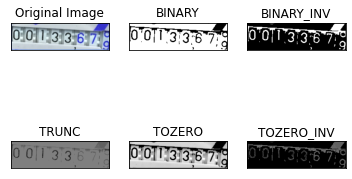

In [8]:
# Verify better threshold for the problem
mask = np.zeros(crop_img.shape, dtype=np.uint8)
gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

ret,thresh1 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(gray,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(gray,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(gray,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [crop_img, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [109]:
# Identify, count and sort the contours
cnts = cv2.findContours(thresh4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="left-to-right")
ROI_number = 0

In [110]:
# Save contours
for c in cnts:
    area = cv2.contourArea(c)
    if area < 700 and area > 70:
        x,y,w,h = cv2.boundingRect(c)
        ROI = 255 - thresh4[y:y+h, x:x+w]
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        cv2.imwrite('img_{}.png'.format(ROI_number), ROI)
        ROI_number += 1

<img src="Figures/img_0.png"> 
<img src="Figures/img_2.png">
<img src="Figures/img_4.png">
<img src="Figures/img_5.png">
<img src="Figures/img_6.png">
<img src="Figures/img_7.png">
<img src="Figures/img_8.png">

Just one mistake. The digit 6 was not recognized.

## Objective of the third part of the project: digit identification by an artificial neural network.

In [113]:
# load training and tests datasets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


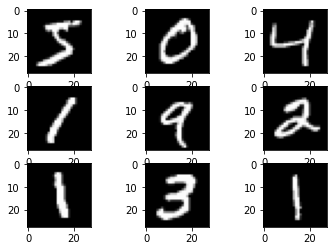

In [121]:
# observe dataset image
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [ ]:
# resizing and normalizing image
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype("float32")
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype("float32")
x_train /= 255
x_test /= 255

In [ ]:
# building artificial neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
     activation='relu',
     input_shape=(img_rows, img_cols, 1)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])

In [ ]:
# Training and save the model
batch_size = 128
epochs = 10

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save("test_model.h5")

### Testing the classifier 

In [119]:
# Carregar o modelo
from keras.models import load_model
model = load_model("test_model.h5")

In [120]:
nomes = ["img1","img2","img3","img4","img5","img6","img7"]

In [132]:
leitura = []
for i in nomes:
    im = cv2.imread(i + ".png")
    gray = np.dot(im[...,:3], [0.299, 0.587, 0.114])
    gray = gray.reshape(1, 28, 28, 1)
    gray /= 255
    # predict digit
    prediction = model.predict(gray)
    leitura.append(prediction.argmax())
print(leitura)

[0, 0, 1, 3, 3, 7, 6]


In [133]:
print("Meter reading: ",*leitura, sep='')

Meter reading: 0013376



### Reading performed by Python-tesseract - optical character recognition (OCR) tool for python

In [51]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [70]:
# Read the image file
image = crop_img

In [71]:
# Resize the image - change width to 500
image = imutils.resize(image, width=500)

In [13]:
gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
cv2.imshow("Grayscale Conversion", gray)
key = cv2.waitKey(0)
cv2.destroyAllWindows()

In [76]:
# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
cv2.imshow("Bilateral Filter", gray)
key = cv2.waitKey(0)
cv2.destroyAllWindows()

In [77]:
# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
cv2.imshow("Canny Edges", edged)
key = cv2.waitKey(0)
cv2.destroyAllWindows()

In [78]:
# Find contours based on Edges
cnts, new  = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [98]:
# Create copy of original image to draw all contours
img1 = image.copy()
cv2.drawContours(img1, cnts, -1, (0,255,0), 2)
cv2.imshow("All Contours", img1)
key = cv2.waitKey(0)
cv2.destroyAllWindows()

In [99]:
#sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30]
NumberPlateCnt = None #we currently have no Number plate contour

In [100]:
# Top 30 Contours
img2 = image.copy()
cv2.drawContours(img2, cnts, -1, (0,255,0), 3)
cv2.imshow("5- Top 30 Contours", img2)
key = cv2.waitKey(0)
cv2.destroyAllWindows()

In [61]:
cv2.imwrite('contornos.png', img2)

True

In [101]:
# loop over our contours to find the best possible approximate contour of number plate
count = 0
idx =7
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.03 * peri, True)
        # print ("approx = ",approx)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour

            # Crop those contours and store it in Cropped Images folder
            x, y, w, h = cv2.boundingRect(c) #This will find out co-ord for plate
            new_img = gray[y:y + h, x:x + w] #Create new image
            cv2.imwrite('Cropped Images-Text/' + str(idx) + '.png', new_img) #Store new image
            idx+=1

            break

In [102]:
Cropped_img_loc = crop_img
cv2.imshow("Cropped Image ", Cropped_img_loc)
key = cv2.waitKey(0)
cv2.destroyAllWindows()

In [103]:
Cropped_img_loc = crop_img

In [104]:
#custom_config = r'--oem 3 --psm 7 outbase digits'
text = pytesseract.image_to_string(crop_img, config="-c tessedit_char_whitelist=0123456789")

In [108]:
# Use tesseract to covert image into string
print("Meter reading: ", text)

Meter reading: 0176


###